# Preprocessing Pipeline 1

In [80]:
### imports base

import pandas as pd
import numpy as np
from scipy import stats

### imports analysis

import matplotlib.pyplot as plt
import seaborn as sns
from dython.nominal import associations

### imports preprocessing

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import (OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler,
                                   FunctionTransformer, PolynomialFeatures, Normalizer)
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin

from category_encoders import OrdinalEncoder, HashingEncoder

from sklearn import set_config
set_config(transform_output='pandas')

### set up system path to access helpers functions

import sys, os
src_path = os.path.abspath(os.path.join(os.getcwd(), '../src'))
if src_path not in sys.path:
  sys.path.append(src_path)

# import helpers
from helpers import *


In [104]:
### import class balancers

from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import make_pipeline

### import classifier models

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay, make_scorer)
from sklearn.inspection import permutation_importance
import shap


- try undersampling, force it look for 1 and not just 0
- select k best
- recursive feature elimination on colab or kaggle server, or some other server

In [82]:
# import merged data

df = pd.read_csv('../data/merged_train.csv')
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,prev_purpose_car_repair,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA,PRODUCT_COMBINATION_Card Street,PRODUCT_COMBINATION_Card X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash Street: high,PRODUCT_COMBINATION_Cash Street: low,PRODUCT_COMBINATION_Cash Street: middle,PRODUCT_COMBINATION_Cash X-Sell: high,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest,PRODUCT_COMBINATION_nan
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,8.0,1.0,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### Feature Name Cleaning

In [83]:
# clean feature names to remove JSON characters to allow LGBClassifier to train

feature_names = df.columns

def clean_feature_names(feature_names):
    return [name.replace('[', '').replace(']', '').replace('<', '')
            .replace('>', '').replace('{', '').replace('}', '')
            .replace(' ', '_').replace('__', '_').replace('/', '_') for name in feature_names]

cleaned_feature_names = clean_feature_names(feature_names)

# convert into dataframe
df = pd.DataFrame(df, columns=cleaned_feature_names)

# Feature Engineering

##### DAYS_EMPLOYED_binary

In [84]:
# create a binary feature for DAYS_EMPLOYED, where unemployed, currently suspected to be indicated by 365243, are 1, else 0

df['DAYS_EMPLOYED_no_job'] = (df['DAYS_EMPLOYED'] == 365243).astype(int)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,prev_purpose_education,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA,PRODUCT_COMBINATION_Card_Street,PRODUCT_COMBINATION_Card_X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash_Street:_high,PRODUCT_COMBINATION_Cash_Street:_low,PRODUCT_COMBINATION_Cash_Street:_middle,PRODUCT_COMBINATION_Cash_X-Sell:_high,PRODUCT_COMBINATION_Cash_X-Sell:_low,PRODUCT_COMBINATION_Cash_X-Sell:_middle,PRODUCT_COMBINATION_POS_household_with_interest,PRODUCT_COMBINATION_POS_household_without_interest,PRODUCT_COMBINATION_POS_industry_with_interest,PRODUCT_COMBINATION_POS_industry_without_interest,PRODUCT_COMBINATION_POS_mobile_with_interest,PRODUCT_COMBINATION_POS_mobile_without_interest,PRODUCT_COMBINATION_POS_other_with_interest,PRODUCT_COMBINATION_POS_others_without_interest,PRODUCT_COMBINATION_nan,DAYS_EMPLOYED_no_job
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,8.0,1.0,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0


OCCUPATION_TYPE_none

In [85]:
# create a binary feature for OCCUPATION_TYPE, where nulls are 0, everything else is 1

df['OCCUPATION_TYPE_none'] = (df['OCCUPATION_TYPE'].isna()).astype(int)
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,...,prev_purpose_everyday,prev_purpose_furniture,prev_purpose_utilities,pre_purpose_hobby,prev_purpose_journey,prev_purpose_medicine,prev_purpose_borrow,prev_purpose_other,prev_purpose_other_loan,prev_purpose_electronic_equip,prev_purpose_refuse,prev_purpose_repairs,prev_purpose_urgent,prev_purpose_wedding,prev_purpose_XAP,prev_purpose_XNA,prev_client_type_repeater,prev_client_type_new,prev_client_type_refreshed,prev_client_type_XNA,PRODUCT_COMBINATION_Card_Street,PRODUCT_COMBINATION_Card_X-Sell,PRODUCT_COMBINATION_Cash,PRODUCT_COMBINATION_Cash_Street:_high,PRODUCT_COMBINATION_Cash_Street:_low,PRODUCT_COMBINATION_Cash_Street:_middle,PRODUCT_COMBINATION_Cash_X-Sell:_high,PRODUCT_COMBINATION_Cash_X-Sell:_low,PRODUCT_COMBINATION_Cash_X-Sell:_middle,PRODUCT_COMBINATION_POS_household_with_interest,PRODUCT_COMBINATION_POS_household_without_interest,PRODUCT_COMBINATION_POS_industry_with_interest,PRODUCT_COMBINATION_POS_industry_without_interest,PRODUCT_COMBINATION_POS_mobile_with_interest,PRODUCT_COMBINATION_POS_mobile_without_interest,PRODUCT_COMBINATION_POS_other_with_interest,PRODUCT_COMBINATION_POS_others_without_interest,PRODUCT_COMBINATION_nan,DAYS_EMPLOYED_no_job,OCCUPATION_TYPE_none
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,297000.0,Unaccompanied,Working,Secondary / secondary special,Civil marriage,House / apartment,0.008019,-19005,-3039,-9833.0,-2437,NaN,1,1,0,1,0,0,Laborers,2.0,2,2,WEDNESDAY,17,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,5.0,8.0,1.0,0.0,0.0,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,513000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.028663,-19932,-3038,-4311.0,-3458,NaN,1,1,0,1,0,0,Core staff,1.0,2,2,THURSDAY,11,0,0,0,0,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,5.0,1.0,0.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0,0


# Drop Outliers

In [86]:
# define the outlier remover custom transformer imported from src.helpers

outlier_remover = OutlierRemover(columns=[], iqr_multiplier=5)

# list the features to remove outliers from

outlier_cols = []

# create the preprocessor

preprocessor_outliers = ColumnTransformer([
  ('outlier_remover', outlier_remover, outlier_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Feature Filter

In [87]:
# create a list of the feature to keep

cols_keep = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','CNT_CHILDREN','AMT_INCOME_TOTAL',
             'AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','NAME_TYPE_SUITE','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE',
             'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','REGION_POPULATION_RELATIVE','DAYS_BIRTH','DAYS_EMPLOYED','DAYS_EMPLOYED_no_job',
             'DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE','FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL',
             'OCCUPATION_TYPE','OCCUPATION_TYPE_none','CNT_FAM_MEMBERS','REGION_RATING_CLIENT','WEEKDAY_APPR_PROCESS_START',
             'HOUR_APPR_PROCESS_START','REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
             'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY']

cols_drop = ['OWN_CAR_AGE','FLAG_MOBIL','FLAG_CONT_MOBILE','REGION_RATING_CLIENT_W_CITY','ORGANIZATION_TYPE']

In [88]:
# create a column transformer to filter unwanted columns

preprocessor_filter = ColumnTransformer([
  ('passthrough', 'passthrough', cols_keep)
], remainder='drop', verbose_feature_names_out=False)

# Imputing

In [89]:
# list the imputing features

impute_freq_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
                        'NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','WEEKDAY_APPR_PROCESS_START',
                        'FLAG_OWN_CAR','FLAG_OWN_REALTY']
impute_zero_cols = ['CNT_CHILDREN','DAYS_EMPLOYED_no_job','OCCUPATION_TYPE_none']
impute_none_cols = ['OCCUPATION_TYPE']
impute_median_cols = ['AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','REGION_POPULATION_RELATIVE',
                      'DAYS_BIRTH','DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','FLAG_EMP_PHONE',
                      'FLAG_WORK_PHONE','FLAG_PHONE','FLAG_EMAIL','REGION_RATING_CLIENT',
                      'REG_REGION_NOT_LIVE_REGION','REG_REGION_NOT_WORK_REGION','LIVE_REGION_NOT_WORK_REGION',
                      'REG_CITY_NOT_LIVE_CITY','REG_CITY_NOT_WORK_CITY','LIVE_CITY_NOT_WORK_CITY','HOUR_APPR_PROCESS_START',
                      'CNT_FAM_MEMBERS']

# assemble the preprocess

preprocessor_imputing = ColumnTransformer([
  ('impute_most_frequent_cat', SimpleImputer(strategy='most_frequent'), impute_freq_cols),
  ('impute_zero', SimpleImputer(strategy='constant', fill_value=0), impute_zero_cols),
  ('impute_none', SimpleImputer(strategy='constant', fill_value='None'), impute_none_cols),
  ('impute_median', SimpleImputer(strategy='median'), impute_median_cols)
], remainder='passthrough', verbose_feature_names_out=False)


# Encoding

In [90]:
# define the encoders

ohe = OneHotEncoder(drop='if_binary', min_frequency=100, sparse_output=False)

# list the encoding features

ohe_cols = ['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE','NAME_INCOME_TYPE',
            'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE','OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_encoding = ColumnTransformer([
  ('ohe', ohe, ohe_cols),
], remainder='passthrough', verbose_feature_names_out=False)

# Log Transform

In [91]:
# list the log features

log_transform_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','CNT_FAM_MEMBERS']

# create a function transformer to do log transformation

def log_transform_df(X):
  return np.log1p(X)

log_transformer = FunctionTransformer(log_transform_df)


# define the preprocessor

preprocessor_log = ColumnTransformer([
  ('log_transformer', log_transformer, log_transform_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Scaling

In [92]:
# list the scaling features

standard_scaler_cols = ['CNT_CHILDREN','AMT_INCOME_TOTAL','AMT_CREDIT','AMT_ANNUITY','AMT_GOODS_PRICE','DAYS_BIRTH',
                        'DAYS_EMPLOYED','DAYS_REGISTRATION','DAYS_ID_PUBLISH','CNT_FAM_MEMBERS','REGION_RATING_CLIENT',
                        'HOUR_APPR_PROCESS_START']

# assemble the preprocessor

preprocessor_scaling = ColumnTransformer([
  ('StandardScaler', StandardScaler(), standard_scaler_cols)
], remainder='passthrough', verbose_feature_names_out=False)

# Train-test-split

In [93]:
# train-test-split

X = df.drop(columns=['SK_ID_CURR','TARGET'])
y = df['TARGET'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Pipeline

In [94]:
# define the main pipe

main_pipe = Pipeline([('preprocessor_filter', preprocessor_filter),
                      ('preprocessor_outliers',preprocessor_outliers),
                      ('preprocessor_imputing', preprocessor_imputing),
                      ('preprocessor_encoding', preprocessor_encoding),
                      ('preprocessor_log', preprocessor_log),
                      ('preprocessor_scaling', preprocessor_scaling)
                      ])

In [95]:
# check the pipe

main_pipe

Pipeline(steps=[('preprocessor_filter',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'FLAG_OWN_REALTY',
                                                   'CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'NAME_TYPE_SUITE',
                                                   'NAME_INCOME_TYPE',
                                                   'NAME_EDUCATION_TYPE',
                                                   'NAME_FAMILY_STATUS',
                                                   'NAME_HOUSING_TYPE',
                                                   'R...
                ('preprocessor_scaling',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'CNT_FAM_MEMBERS',
                                                   'REGION_RATING_CLIENT',
                                                   'HOUR_APPR_PROCESS_START'])],
                                   verbose_feature_names_out=False))])

# Modeling

### 1a. Logistic Regression - Undersampling

Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76    226148
           1       0.13      0.62      0.21     19860

    accuracy                           0.63    246008
   macro avg       0.54      0.62      0.48    246008
weighted avg       0.88      0.63      0.71    246008



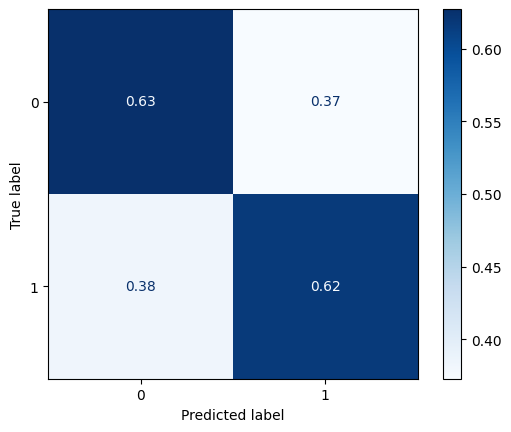

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56538
           1       0.13      0.62      0.21      4965

    accuracy                           0.63     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.88      0.63      0.71     61503



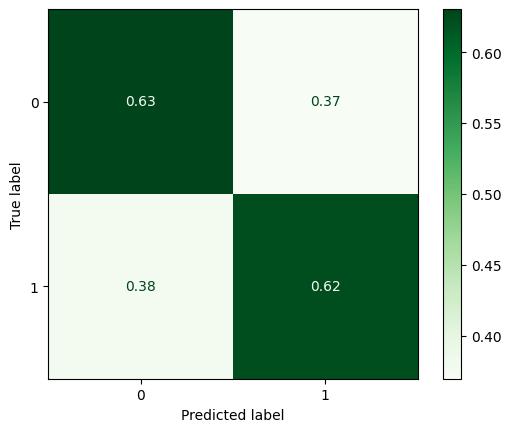

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.626439,0.629872,0.126915,0.128956,0.616969,0.622961,0.210524,0.213679,0.668587,0.670714


In [96]:
# define pipeline for LR
estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, RandomUnderSampler(), LogisticRegression(max_iter=1000))

# check the results

model_results = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR undersampling', pos_label=1)
model_results

### 1b. Logistic Regression - Weighted

Train Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76    226148
           1       0.13      0.62      0.21     19860

    accuracy                           0.63    246008
   macro avg       0.54      0.62      0.48    246008
weighted avg       0.88      0.63      0.71    246008



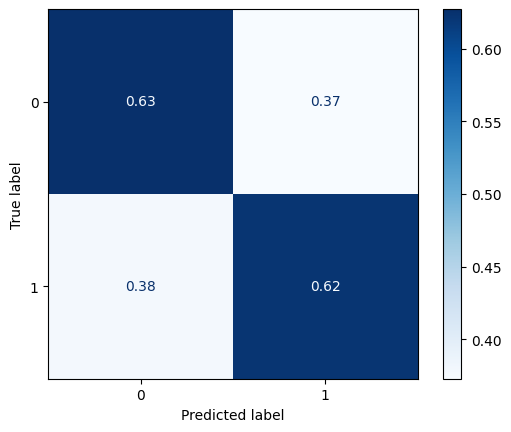

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.63      0.76     56538
           1       0.13      0.62      0.21      4965

    accuracy                           0.63     61503
   macro avg       0.54      0.63      0.49     61503
weighted avg       0.88      0.63      0.71     61503



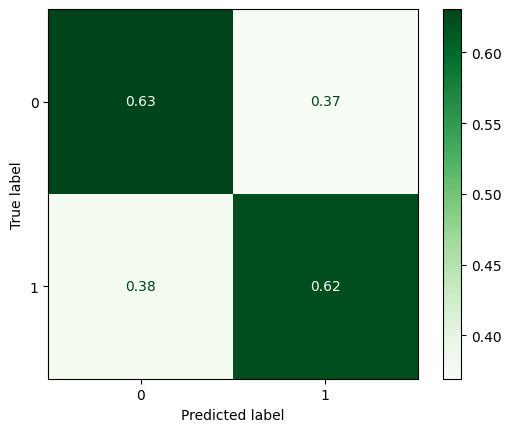

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.626439,0.629872,0.126915,0.128956,0.616969,0.622961,0.210524,0.213679,0.668587,0.670714
LR balanced,0.626760,0.629953,0.127814,0.128921,0.622155,0.622558,0.212062,0.213607,0.672090,0.672750


In [97]:
# define pipeline for LR with weighted classes

estimators = [step[1] for step in main_pipe.steps]

lr_pipe = make_pipeline(*estimators, LogisticRegression(max_iter=1000, class_weight='balanced'))

# check the results

model_results = eval_classification(lr_pipe, X_train, y_train, X_test, y_test, model_name='LR balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 2a. RandomForestClassifier w/GS and balanced 

Train Evaluation
              precision    recall  f1-score   support

           0       0.96      0.69      0.80    226148
           1       0.16      0.65      0.25     19860

    accuracy                           0.69    246008
   macro avg       0.56      0.67      0.53    246008
weighted avg       0.89      0.69      0.76    246008



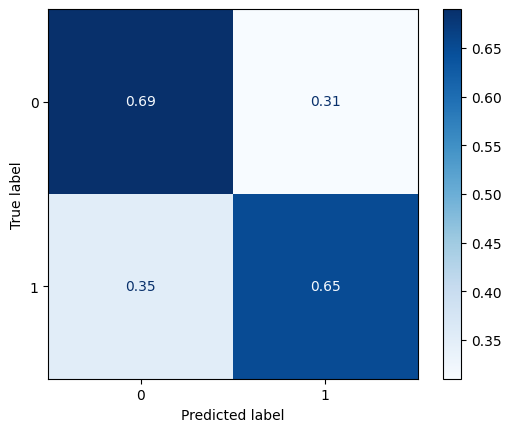

Test Evaluation
              precision    recall  f1-score   support

           0       0.95      0.69      0.80     56538
           1       0.14      0.56      0.22      4965

    accuracy                           0.68     61503
   macro avg       0.54      0.63      0.51     61503
weighted avg       0.88      0.68      0.75     61503



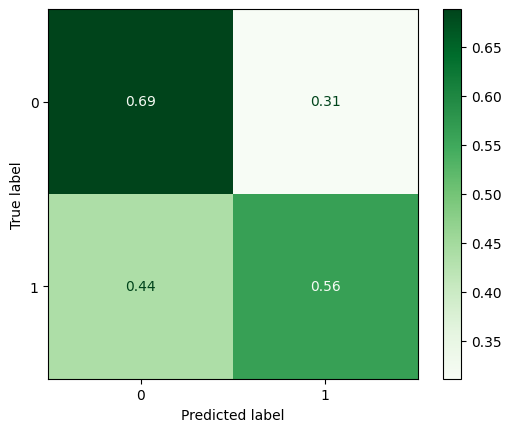

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.626439,0.629872,0.126915,0.128956,0.616969,0.622961,0.210524,0.213679,0.668587,0.670714
LR balanced,0.626760,0.629953,0.127814,0.128921,0.622155,0.622558,0.212062,0.213607,0.672090,0.672750
RF balanced,0.686596,0.678162,0.155255,0.136704,0.648993,0.561934,0.250569,0.219910,0.736374,0.672979


In [98]:
# define pipeline for RF with weighted classes

estimators = [step[1] for step in main_pipe.steps]

rf_pipe = make_pipeline(*estimators, RandomForestClassifier(random_state=42, max_depth=10, n_estimators=500,
                                                            max_features='sqrt', class_weight='balanced'))

# check the results

model_results = eval_classification(rf_pipe, X_train, y_train, X_test, y_test, model_name='RF balanced', pos_label=1,
                                    results_frame=model_results)
model_results

### 2b. RandomForestClassifier with GridSearch

In [99]:
# define grid search params

# rf_pipe = make_pipeline(*estimators, RandomForestClassifier(random_state=42, class_weight='balanced'))

# params = {'randomforestclassifier__max_depth': [10,12,14],
#           'randomforestclassifier__n_estimators': [400,500],
#           'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2']}

# rf_gs = GridSearchCV(rf_pipe, param_grid=params, n_jobs=-1, cv=3, scoring='roc_auc')

# best_params_
# {'randomforestclassifier__max_depth': 12,
#  'randomforestclassifier__max_features': 'sqrt',
#  'randomforestclassifier__n_estimators': 500}

### 3a. SVC balanced

Too big, need to subsample

In [100]:
# define SVC pipe and conduct RandomizedSearch

# svc = SVC(kernel='linear', class_weight='balanced', probability=True)

# estimators = [step[1] for step in main_pipe.steps]
# svc_pipe = make_pipeline(*estimators, svc)

# params = {'svc__C': [0.001, 0.01, .1, 1, 10, 100]}
# svc_rs = RandomizedSearchCV(svc_pipe, param_distributions=params, n_jobs=-1, cv=3, scoring='roc_auc')

# model_results = eval_classification(svc_rs, X_train, y_train, X_test, y_test, model_name='SVC balanced',
#                                     results_frame=model_results)


### 4a. LGBM balanced

has JSON in feature names

In [102]:
# from lightgbm import LGBMClassifier

# lgbc = LGBMClassifier(class_weight='balanced', random_state=42)

# estimators = [step[1] for step in main_pipe.steps]
# lgbc_pipe = make_pipeline(*estimators, lgbc)

# model_results = eval_classification(lgbc_pipe, X_train, y_train, X_test, y_test, model_name='LGBC balanced',
#                                     results_frame=model_results)


### 5a. XBGClassifier

/Users/annahan/Documents/GitHub/learning-fuze/live_class_W1D2_0125/.conda/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:00:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


Train Evaluation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    226148
           1       0.90      0.01      0.03     19860

    accuracy                           0.92    246008
   macro avg       0.91      0.51      0.49    246008
weighted avg       0.92      0.92      0.88    246008



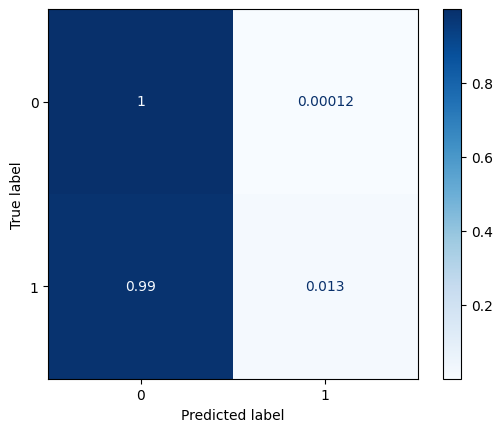

Test Evaluation
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     56538
           1       0.19      0.00      0.00      4965

    accuracy                           0.92     61503
   macro avg       0.55      0.50      0.48     61503
weighted avg       0.86      0.92      0.88     61503



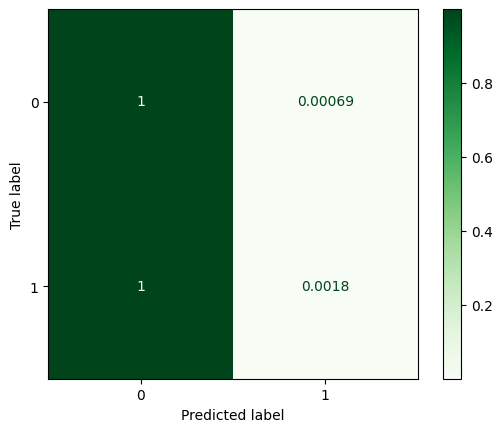

,train_accuracy,test_accuracy,train_precision,test_precision,train_recall,test_recall,train_f1,test_f1,train_auc,test_auc
LR undersampling,0.626439,0.629872,0.126915,0.128956,0.616969,0.622961,0.210524,0.213679,0.668587,0.670714
LR balanced,0.626760,0.629953,0.127814,0.128921,0.622155,0.622558,0.212062,0.213607,0.672090,0.672750
RF balanced,0.686596,0.678162,0.155255,0.136704,0.648993,0.561934,0.250569,0.219910,0.736374,0.672979
XGB balanced,0.920202,0.918784,0.901754,0.187500,0.012941,0.001813,0.025515,0.003591,0.810724,0.689003
XGB balanced,0.920202,0.918784,0.901754,0.187500,0.012941,0.001813,0.025515,0.003591,0.810724,0.689003


In [106]:
# define XGBClassifier

xgb = XGBClassifier(class_weight='balanced', random_state=42)

estimators = [step[1] for step in main_pipe.steps]
xgb_pipe = make_pipeline(*estimators, xgb)

model_results = eval_classification(xgb_pipe, X_train, y_train, X_test, y_test, model_name='XGB balanced',
                                    results_frame=model_results)
model_results